In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os

import tensorflow as tf
import numpy as np

SEED = 1234
np.random.seed(SEED)
tf.random.set_seed(SEED)  

In [3]:
cwd = os.getcwd()

# ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

In [4]:
# Tiling functions

def split_image(image, tile_size):
    """
    Where image is a 3-dimensional tensor, and tile_size is a pair of values [H, W] 
    specifying the size of a tile. The output is a tensor with shape [B, H, W, C].

    Use as: tiles = split_image(image, [256, 256])
    """

    image_shape = tf.shape(image)
    tile_rows = tf.reshape(image, [image_shape[0], -1, tile_size[1], image_shape[2]])
    serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])

    return tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]])


def unsplit_image(tiles, image_shape):
    """
    Where tiles is a 4D tensor of shape [B, H, W, C], and image_shape is 
    the shape of the original image.

    Use as: image = unsplit_image(tiles, [1536, 2048])
    """

    tile_width = tf.shape(tiles)[1]
    serialized_tiles = tf.reshape(tiles, [-1, image_shape[0], tile_width, image_shape[2]])
    rowwise_tiles = tf.transpose(serialized_tiles, [1, 0, 2, 3])

    return tf.reshape(rowwise_tiles, [image_shape[0], image_shape[1], image_shape[2]])


num_tiles = int((1536*2048)/(256*256)) # 48 (dimensioni di bipbip haricot)
img_h = 256
img_w = 256

In [5]:
from PIL import Image

from read_mask_example import read_rgb_mask

class CustomDataset(tf.keras.utils.Sequence):

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'valid.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames) * num_tiles # per ogni immagine ne ho num_tiles in più

  def __getitem__(self, index):
    # Read Image

    i = index // num_tiles    # indice per l'immagine
    tile = index % num_tiles  # indice per il tile data una immagine

    curr_filename = self.subset_filenames[i]
    img = Image.open(os.path.join(self.dataset_dir, 'Images/', curr_filename + '.jpg')) # PIL image
    mask = Image.fromarray(read_rgb_mask(os.path.join(self.dataset_dir, 'Masks/', curr_filename + '.png'))) # PIL image

    tf_img = tf.convert_to_tensor(np.array(img))
    tf_mask = tf.expand_dims(tf.convert_to_tensor(np.array(mask)), 2)
    #print("tf img:", tf_img.shape) # tf img: (1536, 2048, 3)
    #print("tf mask:", tf_mask.shape) # tf mask: (1536, 2048, 1)
    tiles_img = split_image(tf_img, self.out_shape)
    tiles_mask = split_image(tf.expand_dims(tf_mask, 2), self.out_shape)

    
    #print("tile img", tiles_img[tile].shape) # tile img (256, 256, 3)
    #print("tile mask", tiles_mask[tile].shape) # tile mask (256, 256, 1)
    img_arr = np.array(tiles_img[tile])
    mask_arr = np.array(tiles_mask[tile])


    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [6]:
from tensorflow.keras.applications.vgg16 import preprocess_input 


num_classes = 3
dataset_dir = 'D:/OneDrive - Politecnico di Milano/Corsi/2 Anno - 1 Sem/Artificial Neural Networks and Deep Learning/Homework/NNDL/Development_Dataset/Training/Bipbip/Haricot/'


# Set preprocess_input = None to display original image
dataset = CustomDataset(dataset_dir, 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
dataset_valid = CustomDataset(dataset_dir, 'validation', 
                              preprocessing_function=preprocess_input)


In [14]:
bs = 8 # batch size

train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [15]:
# Let's test data generator
# -------------------------
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, num_classes)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0.]


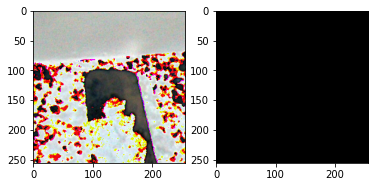

In [16]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   # First element
augmented_img = augmented_img  # denormalize

target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes + 1):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [17]:
# Model Unet

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

def build_unet(shape, num_classes):
    inputs = Input(shape)

    """ Encoder """
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    """ Bridge """
    b1 = conv_block(p4, 128, pool=False)

    """ Decoder """
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    """ Output layer """
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)


model = build_unet((256, 256, 3), 3)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           batch_normalization_18[0][0]     
_______________________________________________________________________________________

In [18]:
# Optimization params

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1, num_classes): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
metrics = ['accuracy', meanIoU]
# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
# Callbacks
callbacks = []

# Early Stopping
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    callbacks.append(es_callback)

# Reduce LR on plateau
reduce_lr = False
if reduce_lr:
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5)
    callbacks.append(reduce_lr_callback)

In [20]:
# Fit the model
model.fit(x=train_dataset,
          epochs=50,  #### set repeat in training dataset
          steps_per_epoch=len(dataset),
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid),
          callbacks=callbacks)

Epoch 1/50
  34/3888 [..............................] - ETA: 3:31:22 - loss: 0.7797 - accuracy: 0.6451 - meanIoU: 0.1803

KeyboardInterrupt: 

In [ ]:
model.save('model_bipbip_haricot_unet_dropout')

In [ ]:
model = tf.keras.models.load_model('model_baseline_bipbip_haricot50', {'meanIoU': meanIoU})

In [ ]:
# Show original, correct, predicted (validation)

iterator = iter(valid_dataset)

In [ ]:
# Show original, correct, predicted (validation)

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)
print(type(image))
image = image[0]
target = target[0, ..., 0]

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, num_classes+1):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes+1):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()

In [ ]:
# Compute predictions

from os import listdir
from os.path import isfile, join, basename, splitext

# CustomTestDataset to load test images
# Specify the full path to the folder containing the images
class CustomTestDataset(tf.keras.utils.Sequence):

    def __init__(self, dataset_dir, img_generator=None, 
              preprocessing_function=None, out_shape=[img_h, img_w]):

      subset_filenames = [splitext(basename(f))[0] for f in 
                                                listdir(dataset_dir) if isfile(join(dataset_dir, f))]

      self.dataset_dir = dataset_dir
      self.subset_filenames = subset_filenames
      self.img_generator = img_generator
      self.preprocessing_function = preprocessing_function
      self.out_shape = out_shape


    def __len__(self):
        return len(self.subset_filenames)


    def get_original_size(self, index):
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.jpg'))
        width, height = img.size

        return [height, width]


    def __getitem__(self, index):
        # Read Image
        curr_filename = self.subset_filenames[index]
        img = Image.open(os.path.join(self.dataset_dir, curr_filename + '.jpg'))

        # Resize image and apply preprocessing function
        img = img.resize(self.out_shape)
        img_arr = np.array(img)

        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)

        return img_arr


    def get_name(self, index):
        return self.subset_filenames[index]

In [ ]:
from prepare_submission import rle_encode
import json

test_dir = 'D:/OneDrive - Politecnico di Milano/Corsi/2 Anno - 1 Sem/Artificial Neural Networks and Deep Learning/Homework/NNDL/Development_Dataset/Test_Dev/Bipbip/Haricot/Images'

test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)

submission_dict = {}

for i in range(test_dataset.__len__()):
    image = test_dataset.__getitem__(i)
    img_name = test_dataset.get_name(i)
    original_h, original_w = test_dataset.get_original_size(i)

    prediction = model.predict(tf.expand_dims(image, axis=0))
    mask_arr = tf.argmax(prediction, -1)[0, ...] # (256, 256)

    # Upscale iamge to original size
    mask_arr = tf.expand_dims(mask_arr, axis=2)
    mask_arr = tf.image.resize(mask_arr, (original_h, original_w),                          
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    mask_arr = np.array(mask_arr)

    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = [original_h, original_w]
    submission_dict[img_name]['team'] = 'Bipbip'
    submission_dict[img_name]['crop'] = 'Haricot'
    submission_dict[img_name]['segmentation'] = {}

    rle_encoded_crop = rle_encode(mask_arr == 1)
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

In [ ]:
# empty submission for other datasets
def empty_submission(team, crop, dir):
    images_dir = join(dir, team, crop, 'Images')
    images_name = [splitext(basename(f))[0] for f in listdir(images_dir) if isfile(join(images_dir, f))]
    
    res = {}
    for img_name in images_name:
        res[img_name] = {}
        res[img_name]['shape'] = [256, 256] # non importa molto la shape per le submission vuote
        res[img_name]['team'] = team
        res[img_name]['crop'] = crop
        res[img_name]['segmentation'] = {}
        res[img_name]['segmentation']['crop'] = ""
        res[img_name]['segmentation']['weed'] = ""

    return res

dir = r'D:\OneDrive - Politecnico di Milano\Corsi\2 Anno - 1 Sem\Artificial Neural Networks and Deep Learning\Homework\NNDL\Development_Dataset\Test_Dev'
submission_dict.update(empty_submission('Bipbip', 'Mais', dir))
submission_dict.update(empty_submission('Pead', 'Haricot', dir))
submission_dict.update(empty_submission('Pead', 'Mais', dir))
submission_dict.update(empty_submission('Roseau', 'Haricot', dir))
submission_dict.update(empty_submission('Roseau', 'Mais', dir))
submission_dict.update(empty_submission('Weedelec', 'Haricot', dir))
submission_dict.update(empty_submission('Weedelec', 'Mais', dir))

with open('./submission.json', 'w') as f:
    json.dump(submission_dict, f)

In [ ]:
# Show original, predicted (test)

test_dataset = CustomTestDataset(test_dir, preprocessing_function=preprocess_input)
test_iter = iter(test_dataset)

In [ ]:
# Show original, predicted (test)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
fig.show()

image = next(test_iter)

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

predicted_class = tf.argmax(out_sigmoid, -1)[0, ...]
print(np.unique(np.array(predicted_class)))

# Assign colors (just for visualization)
prediction_img = np.zeros([image.shape[0], image.shape[1], 3])

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, num_classes+1):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(prediction_img))

fig.canvas.draw()